# Gesture Recognition for Smart TV
**Submitted by**:
   - c
   - a
   - b

#### Accepted gestures:
    - Thumbs up:  Increase the volume
    - Thumbs down: Decrease the volume
    - Left swipe: 'Jump' backwards 10 seconds
    - Right swipe: 'Jump' forward 10 seconds  
    - Stop: Pause the movie

link to final .h5 file - 
https://drive.google.com/file/d/12b5z2JHa2_unG8B9EhIIOv7Vkkmeueut/view?usp=share_link

#### Lets start with importing necessary libraries.

In [6]:
# Importing the necessary libraries

import numpy as np
import os

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [7]:
from skimage.transform import resize as imresize
from imageio import imread

In [8]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf


In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from keras.layers import Dropout

In [11]:
project_folder='datasets/Project_data'

#### Lets create a few helper functions perform repetitve tasks easily.

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Creating our first model. A 3D convolution network.

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2022-12-08 19:46:15.766731: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-08 19:46:15.766806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


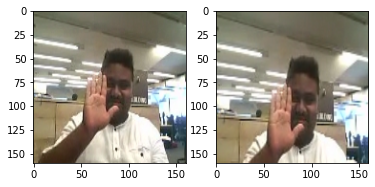

In [11]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

In [12]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [13]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [15]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15


2022-12-08 19:46:28.324166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.5780 - categorical_accuracy: 0.4087
Epoch 00001: val_loss improved from inf to 1.62555, saving model to model_init_2022-12-0819_46_19.191522/model-00001-1.57798-0.40875-1.62555-0.24000.h5
17/17 [==============================] - 139s 8s/step - loss: 1.5780 - categorical_accuracy: 0.4087 - val_loss: 1.6255 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9514 - categorical_accuracy: 0.6259
Epoch 00002: val_loss did not improve from 1.62555
17/17 [==============================] - 140s 9s/step - loss: 0.9514 - categorical_accuracy: 0.6259 - val_loss: 1.9243 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6078 - categorical_accuracy: 0.7768
Epoch 00003: val_loss did not improve from 1.62555
17/17 [==============================] - 129s 8s/step - loss: 0.6078 - categorical_accuracy: 0.7768 - val

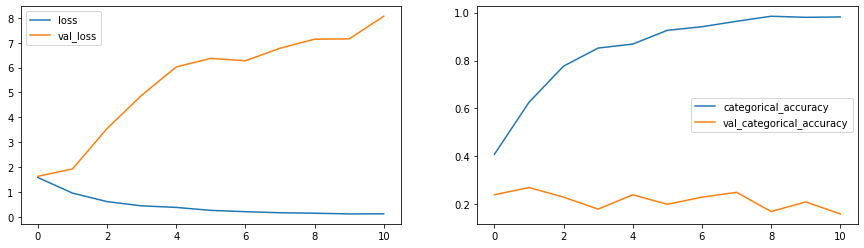

In [16]:
plot(history_model1)

### We can see, out model is overfitting. Lets tackle this by using dropout layers.

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [17]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [18]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8511 - categorical_accuracy: 0.4050
Epoch 00001: val_loss improved from inf to 1.70765, saving model to model_init_2022-12-0820_11_30.467418/model-00001-1.85113-0.40498-1.70765-0.36000.h5
34/34 [==============================] - 249s 7s/step - loss: 1.8511 - categorical_accuracy: 0.4050 - val_loss: 1.7077 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5362 - categorical_accuracy: 0.4367
Epoch 00002: val_loss did not improve from 1.70765
34/34 [==============================] - 255s 8s/step - loss: 1.5362 - categorical_accuracy: 0.4367 - val_loss: 2.6794 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3271 - categorical_accuracy: 0.5264
Epoch 00003: val_loss did not improve from 1.70765
34/34 [==============================] - 248s 8s/step - loss: 1.3271 - c

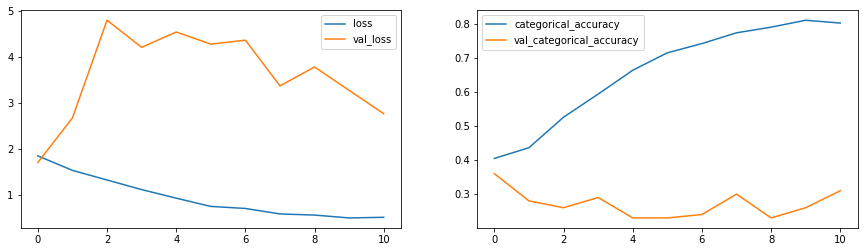

In [19]:
plot(history_model2)

#### We still don't see much improvement in the results.
We will now try to reduce the kernel size.

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [20]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

In [22]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1823 - categorical_accuracy: 0.3009
Epoch 00001: val_loss improved from inf to 1.95355, saving model to model_init_2022-12-0820_56_46.409010/model-00001-2.18232-0.30090-1.95355-0.21000.h5
23/23 [==============================] - 156s 7s/step - loss: 2.1823 - categorical_accuracy: 0.3009 - val_loss: 1.9535 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4954 - categorical_accuracy: 0.4630
Epoch 00002: val_loss did not improve from 1.95355
23/23 [==============================] - 154s 7s/step - loss: 1.4954 - categorical_accuracy: 0.4630 - val_loss: 3.0239 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2404 - categorical_accuracy: 0.5626
Epoch 00003: val_loss did not improve from 1.95355
23/23 [==============================] - 155s 7s/step - loss: 1.

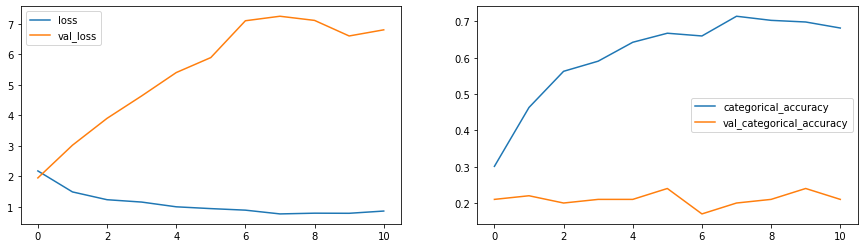

In [23]:
plot(history_model3)

#### Hmm, validation accuracy is still low, lets increase the complexity of our model.

#### We are now adding more layers in our model.

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [24]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_17 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_25 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [26]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8611 - categorical_accuracy: 0.4133
Epoch 00001: val_loss improved from inf to 3.33633, saving model to model_init_2022-12-0821_24_52.264775/model-00001-1.86110-0.41327-3.33633-0.21000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.8611 - categorical_accuracy: 0.4133 - val_loss: 3.3363 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5791 - categorical_accuracy: 0.4759
Epoch 00002: val_loss did not improve from 3.33633
34/34 [==============================] - 158s 5s/step - loss: 1.5791 - categorical_accuracy: 0.4759 - val_loss: 6.6801 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1263 - categorical_accuracy: 0.5965
Epoch 00003: val_loss improved from 3.33633 to 2.02512, saving model to model_init_2022-12-0821_24_52.264775/model-00003-1.

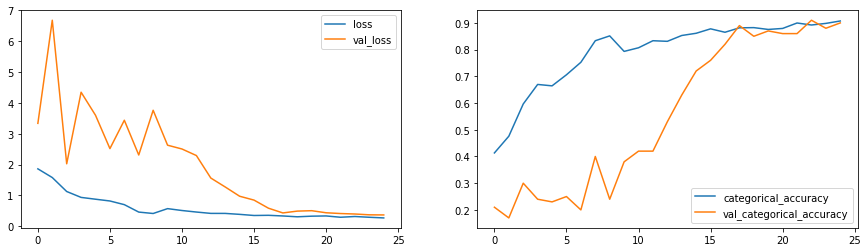

In [27]:
plot(history_model4)

#### The model has improved significantly after adding more layers. We have a  much better model with accuracy around 90%.

#### We will do some more trials to improve model accuracy.

## Model 5 
### Adding dropout at convolution layers

In [28]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_34 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_25 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [30]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7406 - categorical_accuracy: 0.3959
Epoch 00001: val_loss improved from inf to 1.89003, saving model to model_init_2022-12-0822_30_06.807559/model-00001-1.74057-0.39593-1.89003-0.19000.h5
34/34 [==============================] - 156s 5s/step - loss: 1.7406 - categorical_accuracy: 0.3959 - val_loss: 1.8900 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3295 - categorical_accuracy: 0.5000
Epoch 00002: val_loss did not improve from 1.89003
34/34 [==============================] - 157s 5s/step - loss: 1.3295 - categorical_accuracy: 0.5000 - val_loss: 2.2205 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.0857 - categorical_accuracy: 0.6033
Epoch 00003: val_loss did not improve from 1.89003
34/34 [==============================] - 155s 5s/step - loss: 1.0857 - c

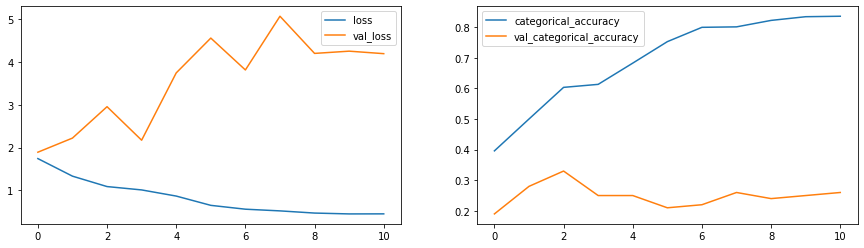

In [31]:
plot(history_model5)

#### The model output has declined again. We need to fix this. This model has lot of parameters.Lets reduce number of paramaters.

## Model 6 
### Reducing the number of parameters

In [32]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_44 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_33 (Activation)  (None, 8, 50, 50, 32)    

In [34]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.9134 - categorical_accuracy: 0.3446
Epoch 00001: val_loss improved from inf to 1.65987, saving model to model_init_2022-12-0822_58_56.193305/model-00001-1.91338-0.34465-1.65987-0.21000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.9134 - categorical_accuracy: 0.3446 - val_loss: 1.6599 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1499 - categorical_accuracy: 0.5799
Epoch 00002: val_loss did not improve from 1.65987
34/34 [==============================] - 161s 5s/step - loss: 1.1499 - categorical_accuracy: 0.5799 - val_loss: 1.7781 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9240 - categorical_accuracy: 0.6365
Epoch 00003: val_loss did not improve from 1.65987
34/34 [==============================] - 153s 5s/step - loss: 0.9

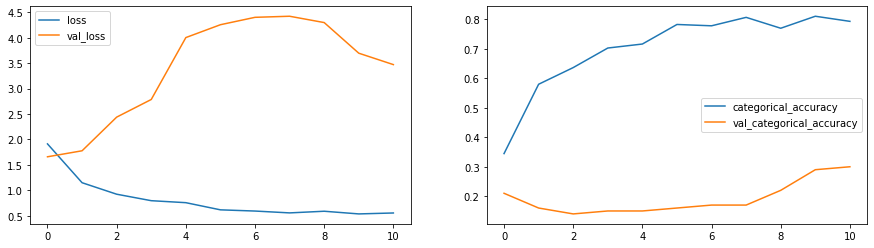

In [35]:
plot(history_model6)

#### We do not see much improvement. Lets further reduce number of paramaters.

## Model 7 - Reducing the number of parameters again

In [36]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_50 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_37 (Activation)  (None, 8, 60, 60, 32)    

In [38]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7952 - categorical_accuracy: 0.3492
Epoch 00001: val_loss improved from inf to 2.07397, saving model to model_init_2022-12-0823_27_01.073484/model-00001-1.79515-0.34917-2.07397-0.18000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.7952 - categorical_accuracy: 0.3492 - val_loss: 2.0740 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2892 - categorical_accuracy: 0.4864
Epoch 00002: val_loss did not improve from 2.07397
34/34 [==============================] - 151s 5s/step - loss: 1.2892 - categorical_accuracy: 0.4864 - val_loss: 3.2950 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0956 - categorical_accuracy: 0.5867
Epoch 00003: val_loss did not improve from 2.07397
34/34 [==============================] - 154s 5s/step - loss: 1.0

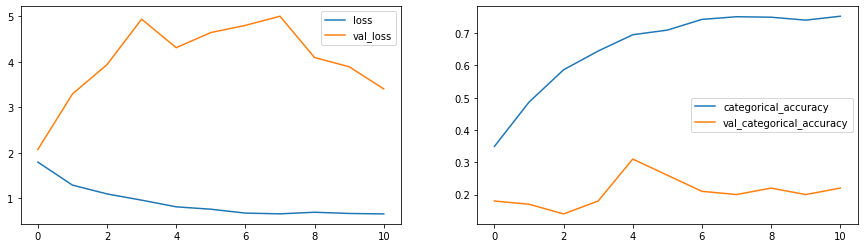

In [39]:
plot(history_model7)

#### The model is still not improved.

#### So, for a 3D-CNN, our model 4 has the best result of 90% accuracy.

#### Lets try to use a CNN_LSTM model and check its performance on given data.

## Model 8 - CNN- LSTM Model

In [40]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [42]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3810 - categorical_accuracy: 0.3914
Epoch 00001: val_loss improved from inf to 1.79013, saving model to model_init_2022-12-0823_55_19.915957/model-00001-1.38103-0.39140-1.79013-0.26000.h5
34/34 [==============================] - 183s 5s/step - loss: 1.3810 - categorical_accuracy: 0.3914 - val_loss: 1.7901 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0886 - categorical_accuracy: 0.5611
Epoch 00002: val_loss did not improve from 1.79013
34/34 [==============================] - 180s 5s/step - loss: 1.0886 - categorical_accuracy: 0.5611 - val_loss: 1.9614 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9698 - categorical_accuracy: 0.6176
Epoch 00003: val_loss did not improve from 1.79013
34/34 [==============================] - 180s 5s/step - loss: 0.9698 - c

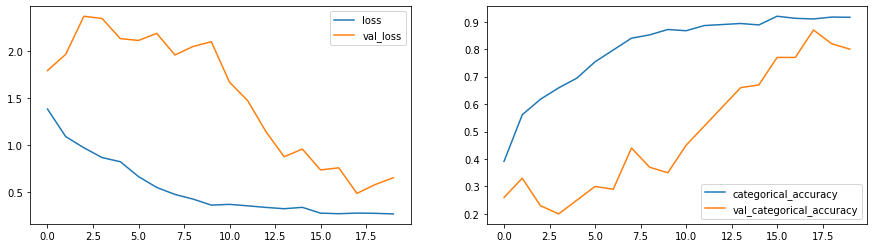

In [43]:
plot(history_model8)

#### We see, this model gives significant model accuracy.
We can improve this further by applying some augmentation techniques.

## Let's apply some data augmentation & check the model performance.

##### Creating helper functions

In [12]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

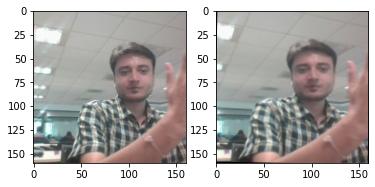

In [13]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [46]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_61 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_41 (Activation)  (None, 10, 80, 80, 32)   

In [48]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8963 - categorical_accuracy: 0.3793
Epoch 00001: saving model to model_init_2022-12-0900_53_03.954895/model-00001-1.89633-0.37934-2.44139-0.21000.h5
34/34 [==============================] - 221s 7s/step - loss: 1.8963 - categorical_accuracy: 0.3793 - val_loss: 2.4414 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3155 - categorical_accuracy: 0.5362
Epoch 00002: saving model to model_init_2022-12-0900_53_03.954895/model-00002-1.31545-0.53620-4.46792-0.21000.h5
34/34 [==============================] - 219s 7s/step - loss: 1.3155 - categorical_accuracy: 0.5362 - val_loss: 4.4679 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0087 - categorical_accuracy: 0.6471
Epoch 00003: saving model to model_init_2022-12-0900_53_03.954895/model-00003-1.00866-0.6470

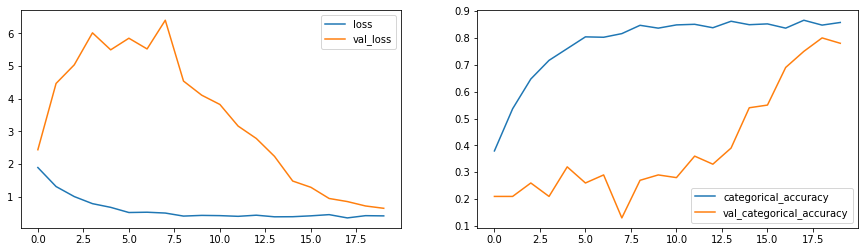

In [49]:
plot(history_model9)

#### We have a good model. Lets try to improve this further.

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [50]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [51]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_44 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_67 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_45 (Activation)  (None, 8, 60, 60, 32)   

In [52]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1071 - categorical_accuracy: 0.3462
Epoch 00001: saving model to model_init_2022-12-0902_06_15.265017/model-00001-2.10706-0.34615-1.80889-0.25000.h5
23/23 [==============================] - 155s 7s/step - loss: 2.1071 - categorical_accuracy: 0.3462 - val_loss: 1.8089 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4479 - categorical_accuracy: 0.5030
Epoch 00002: saving model to model_init_2022-12-0902_06_15.265017/model-00002-1.44788-0.50302-2.61211-0.29000.h5
23/23 [==============================] - 153s 7s/step - loss: 1.4479 - categorical_accuracy: 0.5030 - val_loss: 2.6121 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2784 - categorical_accuracy: 0.5535
Epoch 00003: saving model to model_init_2022-12-0902_06_15.265017/model-00003-1.27842-0.5535

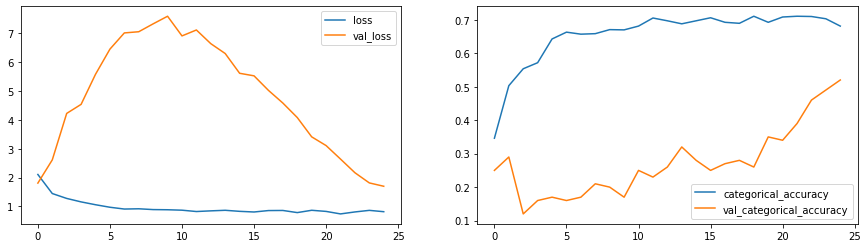

In [53]:
plot(history_model10)

#### The model accuracy has dipped a bit. We will add more layers to tackle this.

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [54]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [55]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_73 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_49 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_49 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_74 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [56]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1860 - categorical_accuracy: 0.3175
Epoch 00001: saving model to model_init_2022-12-0903_09_55.911879/model-00001-2.18599-0.31750-1.87109-0.21000.h5
34/34 [==============================] - 156s 5s/step - loss: 2.1860 - categorical_accuracy: 0.3175 - val_loss: 1.8711 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5909 - categorical_accuracy: 0.4510
Epoch 00002: saving model to model_init_2022-12-0903_09_55.911879/model-00002-1.59095-0.45098-2.47023-0.23000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.5909 - categorical_accuracy: 0.4510 - val_loss: 2.4702 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2642 - categorical_accuracy: 0.5732
Epoch 00003: saving model to model_init_2022-12-0903_09_55.911879/model-00003-1.26424-0.5731

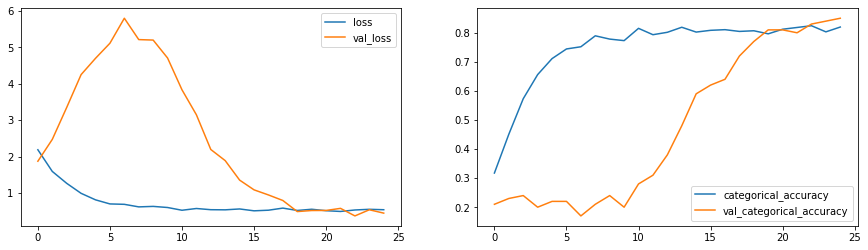

In [57]:
plot(history_model11)

#### We have a good model now. Lets add some dropout layers to make a robust model.

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [58]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [59]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_83 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_57 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_57 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [60]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0230 - categorical_accuracy: 0.3205
Epoch 00001: saving model to model_init_2022-12-0904_15_28.965935/model-00001-2.02304-0.32051-1.68659-0.16000.h5
34/34 [==============================] - 175s 5s/step - loss: 2.0230 - categorical_accuracy: 0.3205 - val_loss: 1.6866 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5961 - categorical_accuracy: 0.4291
Epoch 00002: saving model to model_init_2022-12-0904_15_28.965935/model-00002-1.59612-0.42911-2.10451-0.19000.h5
34/34 [==============================] - 169s 5s/step - loss: 1.5961 - categorical_accuracy: 0.4291 - val_loss: 2.1045 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2959 - categorical_accuracy: 0.5271
Epoch 00003: saving model to model_init_2022-12-0904_15_28.965935/model-00003-1.29592-0.5271

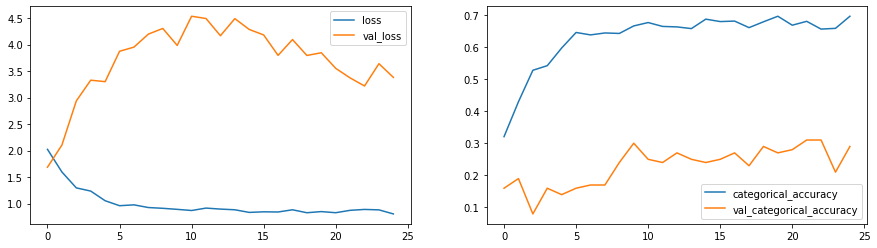

In [61]:
plot(history_model12)

#### The model performance has declined. It is overfitting. Lets reduce the model complexity by reducing parameters.

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [62]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [63]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_64 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_93 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_65 (Activation)  (None, 8, 50, 50, 32)   

In [64]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9000 - categorical_accuracy: 0.3220
Epoch 00001: saving model to model_init_2022-12-0905_21_24.277261/model-00001-1.89999-0.32202-1.88250-0.16000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.9000 - categorical_accuracy: 0.3220 - val_loss: 1.8825 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2333 - categorical_accuracy: 0.5219
Epoch 00002: saving model to model_init_2022-12-0905_21_24.277261/model-00002-1.23329-0.52187-2.89396-0.17000.h5
34/34 [==============================] - 155s 5s/step - loss: 1.2333 - categorical_accuracy: 0.5219 - val_loss: 2.8940 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0387 - categorical_accuracy: 0.6018
Epoch 00003: saving model to model_init_2022-12-0905_21_24.277261/model-00003-1.03874-0.60181

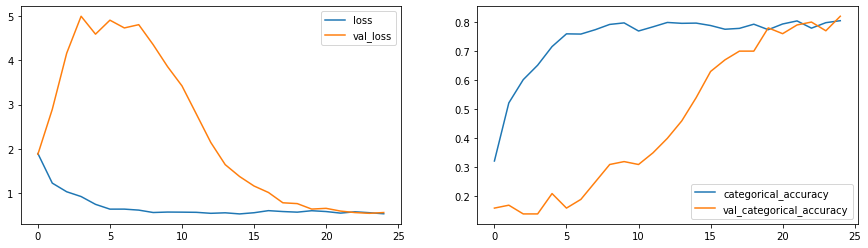

In [65]:
plot(history_model13)

#### Our model has improved with less parameters. We will further reduce the parameters and check model performance.

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [66]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [67]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_99 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_69 (Activation)  (None, 8, 60, 60, 32)   

In [68]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7335 - categorical_accuracy: 0.3484
Epoch 00001: saving model to model_init_2022-12-0906_25_48.141285/model-00001-1.73349-0.34842-2.13966-0.21000.h5
34/34 [==============================] - 161s 5s/step - loss: 1.7335 - categorical_accuracy: 0.3484 - val_loss: 2.1397 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2132 - categorical_accuracy: 0.5339
Epoch 00002: saving model to model_init_2022-12-0906_25_48.141285/model-00002-1.21315-0.53394-3.73491-0.18000.h5
34/34 [==============================] - 156s 5s/step - loss: 1.2132 - categorical_accuracy: 0.5339 - val_loss: 3.7349 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0812 - categorical_accuracy: 0.5747
Epoch 00003: saving model to model_init_2022-12-0906_25_48.141285/model-00003-1.08121-0.57466

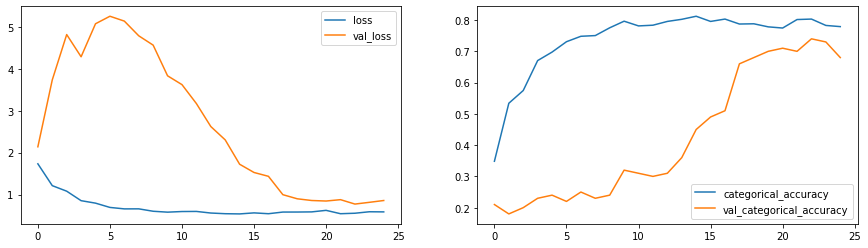

In [69]:
plot(history_model14)

#### We see our model is slightly overfitting. Lets use gated units and see how the model behaves.

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [70]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [71]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32) 

In [72]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4658 - categorical_accuracy: 0.3733
Epoch 00001: saving model to model_init_2022-12-0907_31_52.249249/model-00001-1.46576-0.37330-2.08917-0.21000.h5
34/34 [==============================] - 186s 6s/step - loss: 1.4658 - categorical_accuracy: 0.3733 - val_loss: 2.0892 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0501 - categorical_accuracy: 0.5905
Epoch 00002: saving model to model_init_2022-12-0907_31_52.249249/model-00002-1.05009-0.59050-3.26950-0.19000.h5
34/34 [==============================] - 179s 5s/step - loss: 1.0501 - categorical_accuracy: 0.5905 - val_loss: 3.2695 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7889 - categorical_accuracy: 0.6991
Epoch 00003: saving model to model_init_2022-12-0907_31_52.249249/model-00003-0.78886-0.6991

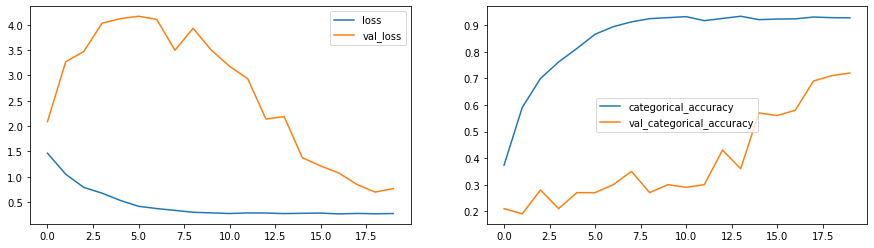

In [73]:
plot(history_model15)

#### Even the gated units did not improve the model performance.

#### We will take help of transfer learning. We will be using a pre-trained imagenet network with required modifications.

## Model 16 - Using Transfer Learning 

In [ ]:
from keras.applications import mobilenet

In [75]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 2s 0us/step


In [76]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [77]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2979 - categorical_accuracy: 0.4532
Epoch 00001: saving model to model_init_2022-12-0908_36_02.355012/model-00001-1.29792-0.45324-0.92266-0.61000.h5
133/133 [==============================] - 170s 1s/step - loss: 1.2979 - categorical_accuracy: 0.4532 - val_loss: 0.9227 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7650 - categorical_accuracy: 0.7081
Epoch 00002: saving model to model_init_2022-12-0908_36_02.355012/model-00002-0.76500-0.70814-0.73216-0.69000.h5
133/133 [==============================] - 170s 1s/step - loss: 0.7650 - categorical_accuracy: 0.7081 - val_loss: 0.7322 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6276 - categorical_accuracy: 0.7489
Epoch 00003: saving model to model_init_2022-12-0908_36_02.355012/model-00003-0.62756-0.74

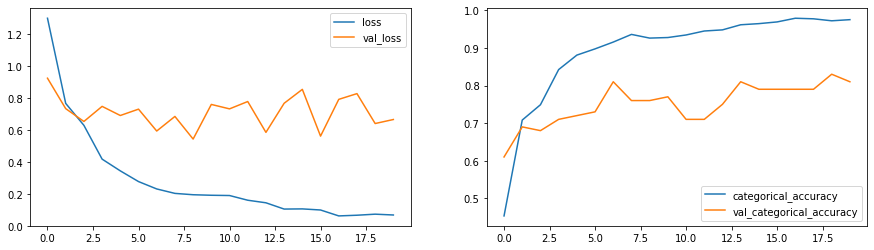

In [78]:
plot(history_model16)

#### This model can be improved if we add gated units. Lets do that.

## Model 17 - Transfer Learning with GRU and training all weights

In [14]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [81]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.0701 - categorical_accuracy: 0.5777
Epoch 00001: saving model to model_init_2022-12-0909_31_54.594618/model-00001-1.07014-0.57768-0.45720-0.83000.h5
133/133 [==============================] - 167s 1s/step - loss: 1.0701 - categorical_accuracy: 0.5777 - val_loss: 0.4572 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.5076 - categorical_accuracy: 0.8273
Epoch 00002: saving model to model_init_2022-12-0909_31_54.594618/model-00002-0.50764-0.82730-0.73583-0.73000.h5
133/133 [==============================] - 167s 1s/step - loss: 0.5076 - categorical_accuracy: 0.8273 - val_loss: 0.7358 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4233 - categorical_accuracy: 0.8552
Epoch 00003: saving model to model_init_2022-12-0909_31_54.594618/model-00003-0.42330-0.85

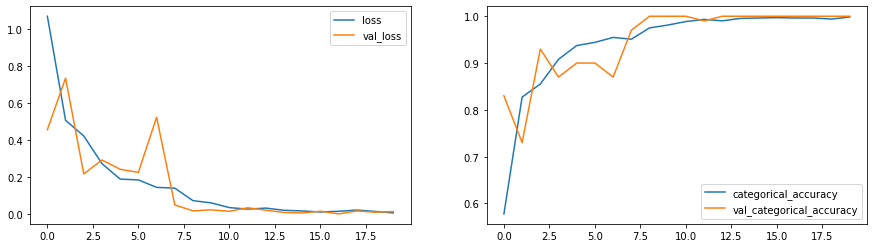

In [82]:
plot(history_model17)

#### We see that the accuracy of this model is better than all other models.
#### So, we choose this as our final model.

#### We have saved the h5 file for this model. We will now load that and check model performance.

In [83]:
import time
from keras.models import load_model
model = load_model('model_init_2022-12-0909_31_54.594618/model-00020-0.00732-0.99849-0.01472-1.00000.h5')


In [16]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)

a =rnn_cnn_tl2.generator(rnn_cnn_tl2.val_path,rnn_cnn_tl2.val_doc,augment=False)
batch_data, batch_labels=next(a) 

In [17]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [18]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4 1 3 0 2]


#### The predicted class labels matches the images given to the model. So, we have a working Gesture recognition model.